In [1]:
import glob

import math
import numpy as np
import pandas as pd
import dask.dataframe as dd

import geopandas as gpd
import pyproj
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

from sqlalchemy import create_engine
import plotly.express as px

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pandas_profiling import ProfileReport
plt.style.use('ggplot')
%matplotlib inline

## Features in the dataset:
<table aligh="left">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka "store and forward," because the vehicle did not have a connection to the server.<br\>Y= store and forward trip<br\>N= not a store and forward trip</td>
	</tr>
	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the \$0.50 and \$1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

In [2]:
dd_df = dd.read_parquet("Data/")

In [3]:
taxi_zone_lookup=pd.read_csv('taxi_zone_lookup.csv')

In [4]:
dd_df=dd_df.merge(taxi_zone_lookup[['LocationID', 'Borough', 'Zone']], left_on='PULocationID', right_on='LocationID').merge(taxi_zone_lookup[['LocationID', 'Borough', 'Zone']], left_on='DOLocationID', right_on='LocationID', suffixes=['_pickup','_dropoff']).drop(['PULocationID','DOLocationID'],axis=1).rename(columns={'tpep_dropoff_datetime':'dropoff_datetime','tpep_pickup_datetime':'pickup_datetime','LocationID_dropoff':'dropoff_LocationID','Borough_dropoff':'dropoff_Borough','Zone_dropoff':'dropoff_Zone','LocationID_pickup':'pickup_LocationID','Borough_pickup':'pickup_Borough','Zone_pickup':'pickup_Zone'})

In [5]:
dd_df['pickup_hour']=dd_df['pickup_datetime'].astype(str).str[11:13].astype(int)
dd_df['dropoff_hour']=dd_df['dropoff_datetime'].astype(str).str[11:13].astype(int)
dd_df['trip_date']=dd_df['pickup_datetime'].dt.date
dd_df['trip_month']=dd_df['pickup_datetime'].dt.to_period('M').astype(str)
dd_df['trip_duration'] = (dd_df['dropoff_datetime'] - dd_df['pickup_datetime']).astype('timedelta64[s]')
dd_df['trip_avg_speed'] = 60*60*dd_df['trip_distance']/dd_df['trip_duration']
dd_df['trip_type']='short'
dd_df[dd_df['trip_distance']>30]['trip_type']='long'

In [6]:
dd_df=dd_df[(dd_df['pickup_datetime'] > "2021-06-30 23:59:59") & (dd_df['pickup_datetime'] < "2022-07-01 00:00:00")]
dd_df=dd_df.query("pickup_LocationID >= 1 & pickup_LocationID <= 263 & dropoff_LocationID >= 1 & dropoff_LocationID <= 263 & trip_duration>60 & trip_duration <= 43200 & trip_avg_speed > 0 & trip_avg_speed < 60 & trip_distance > 0 & trip_distance <= 36 & total_amount > 0 & total_amount < 1000")

In [7]:
dd_df_2022=dd_df[(dd_df['pickup_datetime'] > "2021-12-31 23:59:59")]

In [8]:
df_2022=dd_df_2022.compute()

In [45]:
df_2022.head()

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,...,dropoff_LocationID,dropoff_Borough,dropoff_Zone,pickup_hour,dropoff_hour,trip_date,trip_month,trip_duration,trip_avg_speed,trip_type
292400,2,2022-02-20 13:44:31,2022-02-20 21:54:36,2.0,1.60,1.0,N,1,8.0,0.0,...,162,Manhattan,Midtown East,13,21,2022-02-20,2022-02,29405.0,0.195885,short
319692,2,2022-01-08 20:51:58,2022-01-08 21:23:50,4.0,4.90,1.0,N,1,22.5,0.0,...,162,Manhattan,Midtown East,20,21,2022-01-08,2022-01,1912.0,9.225941,short
404129,2,2022-01-11 13:47:13,2022-01-11 13:55:25,2.0,0.66,1.0,N,2,6.5,0.0,...,141,Manhattan,Lenox Hill West,13,13,2022-01-11,2022-01,492.0,4.829268,short
463490,2,2022-01-08 21:34:04,2022-01-08 21:40:08,4.0,1.16,1.0,N,2,6.0,0.0,...,140,Manhattan,Lenox Hill East,21,21,2022-01-08,2022-01,364.0,11.472527,short
483880,2,2022-01-09 10:21:15,2022-01-09 10:36:15,3.0,3.31,1.0,N,2,13.0,0.0,...,140,Manhattan,Lenox Hill East,10,10,2022-01-09,2022-01,900.0,13.240000,short


In [46]:
df_2022.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'pickup_LocationID', 'pickup_Borough', 'pickup_Zone',
       'dropoff_LocationID', 'dropoff_Borough', 'dropoff_Zone', 'pickup_hour',
       'dropoff_hour', 'trip_date', 'trip_month', 'trip_duration',
       'trip_avg_speed', 'trip_type'],
      dtype='object')

C:\Python\Anaconda3\lib\site-packages\dask\dataframe\core.py:6560: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [50]:
df_2022_hourly_avg = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'tolls_amount', 'total_amount', 'airport_fee', 'fare_amount', 'trip_duration', 'trip_distance', 'congestion_surcharge']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'], as_index=False).mean()

In [137]:
df_2022_hourly_count = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'], as_index=False).size().rename(columns={"size": "trips"})

In [ ]:
df_2022_hourly_mode_1 = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'dropoff_Borough']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'])['dropoff_Borough'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index() 

In [ ]:
df_2022_hourly_mode_2 = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'dropoff_Zone']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'])['dropoff_Zone'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()

In [126]:
df_2022_hourly_mode_3_1 = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'RatecodeID']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone','RatecodeID'],as_index=False).size()
df_2022_hourly_mode_3_2=df_2022_hourly_mode_3_1[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'size']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'],as_index=False).max()
df_2022_hourly_mode_3=df_2022_hourly_mode_3_1.merge(df_2022_hourly_mode_3_2, on=['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'],suffixes=['_all','_max'])
df_2022_hourly_mode_3=df_2022_hourly_mode_3[df_2022_hourly_mode_3['size_all'] == df_2022_hourly_mode_3['size_max']][['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'RatecodeID']]
df_2022_hourly_mode_3.drop_duplicates(subset = ['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'], keep = 'first', inplace = True) 

In [60]:
df_2022_hourly_mode_4 = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'payment_type']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'])['payment_type'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()

In [127]:
df_2022_hourly_mode_5_1 = df_2022[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'passenger_count']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone','passenger_count'],as_index=False).size()
df_2022_hourly_mode_5_2=df_2022_hourly_mode_5_1[['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'size']].groupby(['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'],as_index=False).max()
df_2022_hourly_mode_5=df_2022_hourly_mode_5_1.merge(df_2022_hourly_mode_5_2, on=['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'],suffixes=['_all','_max'])
df_2022_hourly_mode_5=df_2022_hourly_mode_5[df_2022_hourly_mode_5['size_all'] == df_2022_hourly_mode_5['size_max']][['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone', 'passenger_count']]
df_2022_hourly_mode_5.drop_duplicates(subset = ['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone'], keep = 'first', inplace = True) 

In [138]:
from functools import reduce
df_2022_hourly = reduce(lambda  left,right: pd.merge(left,right,how='outer',on=['trip_date', 'pickup_hour','pickup_LocationID','pickup_Borough','pickup_Zone']), [df_2022_hourly_count, df_2022_hourly_avg, df_2022_hourly_mode_1,df_2022_hourly_mode_2,df_2022_hourly_mode_3,df_2022_hourly_mode_4,df_2022_hourly_mode_5])

In [140]:
df_2022_hourly.to_csv('nyc_hourly_data_2022.csv', index=False)

In [9]:
pick_up_trips_zone = dd_df_2022.groupby(['pickup_LocationID','pickup_Borough','pickup_Zone']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_trips_zone = dd_df_2022.groupby(['dropoff_LocationID','dropoff_Borough','dropoff_Zone']).size().reset_index().rename(columns={0:'total_trips'}).compute()
pick_up_trips_borough = dd_df_2022.groupby(['pickup_Borough']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_trips_borough = dd_df_2022.groupby(['dropoff_Borough']).size().reset_index().rename(columns={0:'total_trips'}).compute()

In [10]:
pick_up_hrs = dd_df_2022.groupby(['pickup_hour']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_hrs = dd_df_2022.groupby(['dropoff_hour']).size().reset_index().rename(columns={0:'total_trips'}).compute()
type_of_distance = dd_df_2022.groupby(['trip_type']).size().reset_index().rename(columns={0:'total_trips'}).compute()
pick_up_hrs_distance = dd_df_2022.groupby(['pickup_hour','trip_type']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_hrs_distance = dd_df_2022.groupby(['dropoff_hour','trip_type']).size().reset_index().rename(columns={0:'total_trips'}).compute()

In [11]:
trips_zone_distance = dd_df_2022.groupby(['pickup_LocationID','dropoff_LocationID','pickup_Zone','dropoff_Zone','pickup_Borough','dropoff_Borough','trip_type']).size().reset_index().rename(columns={0:'total_trips'}).compute()
trips_borough_distance = dd_df_2022.groupby(['pickup_Borough','dropoff_Borough','trip_type']).size().reset_index().rename(columns={0:'total_trips'}).compute()

In [ ]:
pick_up_trips_zone = dd_df_2022.groupby(['pickup_LocationID','pickup_Borough','pickup_Zone']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_trips_zone = dd_df_2022.groupby(['dropoff_LocationID','dropoff_Borough','dropoff_Zone']).size().reset_index().rename(columns={0:'total_trips'}).compute()
pick_up_trips_borough = dd_df_2022.groupby(['pickup_Borough']).size().reset_index().rename(columns={0:'total_trips'}).compute()
drop_off_trips_borough = dd_df_2022.groupby(['dropoff_Borough']).size().reset_index().rename(columns={0:'total_trips'}).compute()

# DONT RUN

In [7]:
total_trips = df.groupby(['trip_month','PULocationID','DOLocationID']).size()
trip_amount = df[['trip_month','PULocationID','DOLocationID','total_amount']].groupby(['trip_month','PULocationID','DOLocationID']).sum()
trip_duration = df[['trip_month','PULocationID','DOLocationID','trip_duration']].groupby(['trip_month','PULocationID','DOLocationID']).sum()

In [32]:
total_trips_pickup = total_trips.groupby(['trip_month','PULocationID']).sum().reset_index().rename(columns={0:'total_trips'}).compute()
total_trips_drop = total_trips.groupby(['trip_month','DOLocationID']).sum().reset_index().rename(columns={0:'total_trips'}).compute()
trip_amount_pickup = trip_amount.groupby(['trip_month','PULocationID']).sum().reset_index().rename(columns={0:'total_trip_amount'}).compute()
trip_amount_drop = trip_amount.groupby(['trip_month','DOLocationID']).sum().reset_index().rename(columns={0:'total_trip_amount'}).compute()
trip_duration_pickup = trip_duration.groupby(['trip_month','PULocationID']).sum().reset_index().rename(columns={0:'total_trip_duration'}).compute()
trip_duration_drop = trip_duration.groupby(['trip_month','DOLocationID']).sum().reset_index().rename(columns={0:'total_trip_duration'}).compute()

In [33]:
trip_amount_pickup_avg = trip_amount_pickup.merge(total_trips_pickup, how="inner", on=['trip_month','PULocationID'])
trip_duration_pickup_avg = trip_duration_pickup.merge(total_trips_pickup, how="inner", on=['trip_month','PULocationID'])
trip_amount_drop_avg = trip_amount_drop.merge(total_trips_drop, how="inner", on=['trip_month','DOLocationID'])
trip_duration_drop_avg = trip_duration_drop.merge(total_trips_drop, how="inner", on=['trip_month','DOLocationID'])

In [37]:
trip_amount_pickup_avg['average_trip_amount']=trip_amount_pickup_avg['total_amount']/trip_amount_pickup_avg['total_trips']
trip_duration_pickup_avg['average_trip_duration']=trip_duration_pickup_avg['trip_duration']/trip_duration_pickup_avg['total_trips']
trip_amount_drop_avg['average_trip_amount']=trip_amount_drop_avg['total_amount']/trip_amount_drop_avg['total_trips']
trip_duration_drop_avg['average_trip_duration']=trip_duration_drop_avg['trip_duration']/trip_duration_drop_avg['total_trips']

In [98]:
pickup_data = map_df[['LocationID','zone','borough','geometry']].merge(trip_amount_pickup_avg.merge(trip_duration_pickup_avg, how='inner', on = ['trip_month','PULocationID','total_trips']), how="inner", left_on="LocationID", right_on="PULocationID").drop(['PULocationID'], axis=1)
drop_data = map_df[['LocationID','zone','borough','geometry']].merge(trip_amount_drop_avg.merge(trip_duration_drop_avg, how='inner', on = ['trip_month','DOLocationID','total_trips']), how="inner", left_on="LocationID", right_on="DOLocationID").drop(['DOLocationID'], axis=1)

In [103]:
fig = px.choropleth(pickup_data, geojson=pickup_data.geometry, locations=pickup_data.LocationID, color="total_trips", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('total_trips_pickup.html')

In [104]:
fig = px.choropleth(pickup_data, geojson=pickup_data.geometry, locations=pickup_data.LocationID, color="average_trip_amount", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('average_trip_amount_pickup.html')

In [105]:
fig = px.choropleth(pickup_data, geojson=pickup_data.geometry, locations=pickup_data.LocationID, color="average_trip_duration", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('average_trip_duration_pickup.html')

In [106]:
fig = px.choropleth(drop_data, geojson=drop_data.geometry, locations=drop_data.LocationID, color="total_trips", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('total_trips_drop.html')

In [107]:
fig = px.choropleth(drop_data, geojson=drop_data.geometry, locations=drop_data.LocationID, color="average_trip_amount", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('average_trip_amount_drop.html')

In [108]:
fig = px.choropleth(drop_data, geojson=drop_data.geometry, locations=drop_data.LocationID, color="average_trip_duration", animation_frame="trip_month", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('average_trip_duration_drop.html')

# RUN

In [15]:
def get_centroid(map_data):
    data = []
    for sr in map_data.shapeRecords():
        shape = sr.shape
        record = sr.record
        location_id = record[map_dict['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        data.append((location_id, x, y))
    return pd.DataFrame(data, columns=["LocationID", "longitude", "latitude"])

In [16]:
map_data = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in map_data.fields[1:]]
map_dict = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = map_data.records()
map_attr_dict = [dict(zip(fields_name, attr)) for attr in attributes]
map_df = pd.DataFrame(map_attr_dict).join(get_centroid(map_data).set_index("LocationID"), on="LocationID")

In [17]:
map_df.at[56,'LocationID']=57
map_df.at[103,'LocationID']=104
map_df.at[104,'LocationID']=105

In [18]:
def add_margins(map_data):
    latitude, longitude = [], []
    for shape in list(map_data.iterShapes()):
        latitude.extend([shape.bbox[0], shape.bbox[2]])
        longitude.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    min_latitude = min(latitude) - margin
    max_latitude = max(latitude) + margin
    min_longitude = min(longitude) - margin
    max_longitude = max(longitude) + margin

    return min_latitude, max_latitude, min_longitude, max_longitude

In [131]:
def plot_region(ax, map_data, data={}, r=True):
    
    region_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    region_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    region_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(data) != 0:
        cmap=plt.get_cmap('Reds')
        norm=mpl.colors.Normalize(vmin=math.sqrt(min(data.values())), vmax=math.sqrt(max(data.values())))
        #scalar = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
        #scalar.set_array([])
        #plt.colorbar(scalar, ticks=np.linspace(min(data.values()),max(data.values()),8), boundaries=np.arange(min(data.values())-10,max(data.values())+10,.1))
    
    ax.set_facecolor('w')
    for sr in map_data.shapeRecords():
        shape = sr.shape
        record = sr.record
        region_name = record[map_dict['borough']]
        
        if len(data) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6)
            cmap = plt.get_cmap('Pastel1')
            R,G,B,A = cmap(norm(region_list[region_name]))
            color = [R,G,B]
        else:
            R,G,B,A = cmap(norm(math.sqrt(data[region_name])))
            color = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        parts = len(shape.parts) # total parts
        if parts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for i in range(parts): # loop over parts, plot separately
                _0 = shape.parts[i]
                if i < parts-1:
                    _1 = shape.parts[i+1]-1
                else:
                    _1 = len(shape.points)

                polygon = Polygon(shape.points[_0:_1+1])
                patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        region_x[region_name].append((shape.bbox[0]+shape.bbox[2])/2)
        region_y[region_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in region_list:
        if len(data)==0:
            plt.text(np.mean(region_x[k]), np.mean(region_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            if r:
                plt.text(np.mean(region_x[k]), np.mean(region_y[k]), "{}\n({}K)".format(k, data[k]/1000), horizontalalignment='center',  verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       
            else:
                plt.text(np.mean(region_x[k]), np.mean(region_y[k]), "{}\n({})".format(k, round(data[k],2)), horizontalalignment='center',  verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = add_margins(map_data)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

In [133]:
def plot_zone(ax, map_data, data={}, text=[], arrows=[]):
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_alpha(0)
    
    # colorbar
    if len(data) != 0:
        norm=mpl.colors.Normalize(vmin=min(data.values()),vmax=max(data.values()))
        cmap=plt.get_cmap('Reds')
        scalar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        scalar.set_array([])
        plt.colorbar(scalar, ticks=np.linspace(min(data.values()),max(data.values()),8),
                     boundaries=np.arange(min(data.values())-10,max(data.values())+10,.1))
    ax.set_facecolor('w')
    for sr in map_data.shapeRecords():
        shape = sr.shape
        record = sr.record
        location_id = record[map_dict['LocationID']]
        zone = record[map_dict['zone']]
        
        if len(data) == 0:
            color = [235/256, 151/256, 78/256]
        else:
            if location_id not in data:
                R,G,B,A = cmap(norm(0))
            else:
                R,G,B,A = cmap(norm(data[location_id]))
            color = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        parts = len(shape.parts) # total parts
        if parts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for i in range(parts): # loop over parts, plot separately
                _0 = shape.parts[i]
                if i < parts-1:
                    _1 = shape.parts[i+1]-1
                else:
                    _1 = len(shape.points)

                polygon = Polygon(shape.points[_0:_1+1])
                patch = PolygonPatch(polygon, facecolor=color, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and record[map_dict['Shape_Area']] > 0.0001):
            plt.text(x, y, str(location_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and location_id in text:
            plt.text(x+0.01, y-0.01, str(location_id), fontsize=12, color="white", bbox=dict(facecolor='white', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(location_id)])
            eta_y = 0.05*np.sin(theta[text.index(location_id)])
            ax.annotate("[{}] {}".format(location_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = add_margins(map_data)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

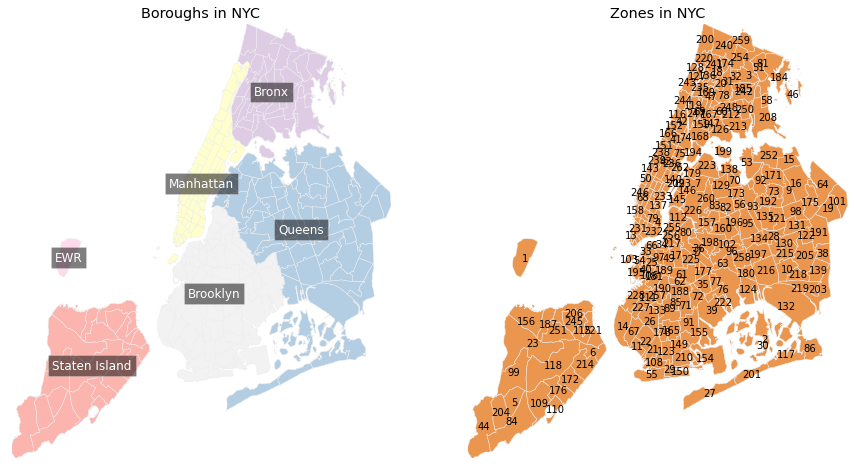

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
plot_region(ax, map_data)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
plot_zone(ax, map_data)

In [34]:
data_zone=pick_up_trips_zone.merge(drop_off_trips_zone,left_on='pickup_LocationID', right_on='dropoff_LocationID', suffixes=['_pickup','_dropoff'])
data_borough=pick_up_trips_borough.merge(drop_off_trips_borough,left_on='pickup_Borough', right_on='dropoff_Borough', suffixes=['_pickup','_dropoff'])

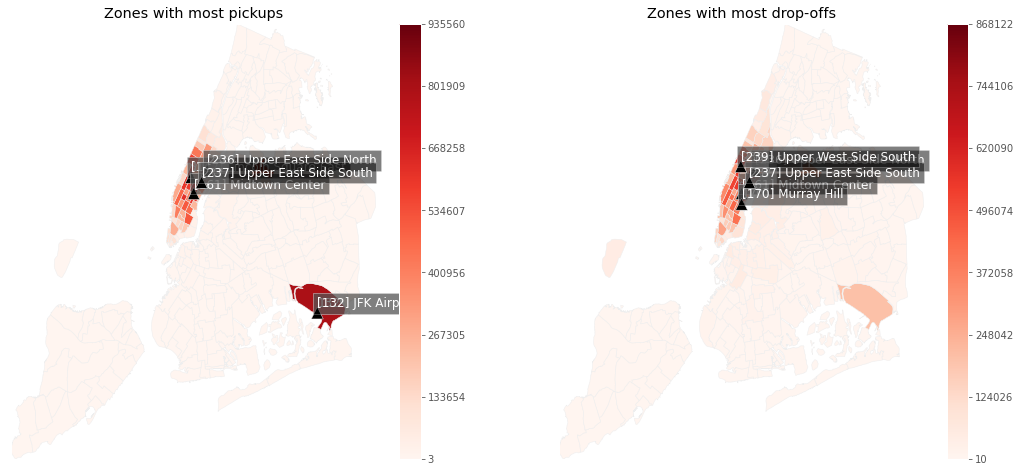

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
plot_zone(ax, map_data, data=dict(zip(data_zone['pickup_LocationID'].tolist(), data_zone['total_trips_pickup'].tolist())), text=data_zone.sort_values(by=['total_trips_pickup'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
plot_zone(ax, map_data, data=dict(zip(data_zone['pickup_LocationID'].tolist(), data_zone['total_trips_dropoff'].tolist())), text=data_zone.sort_values(by=['total_trips_dropoff'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())

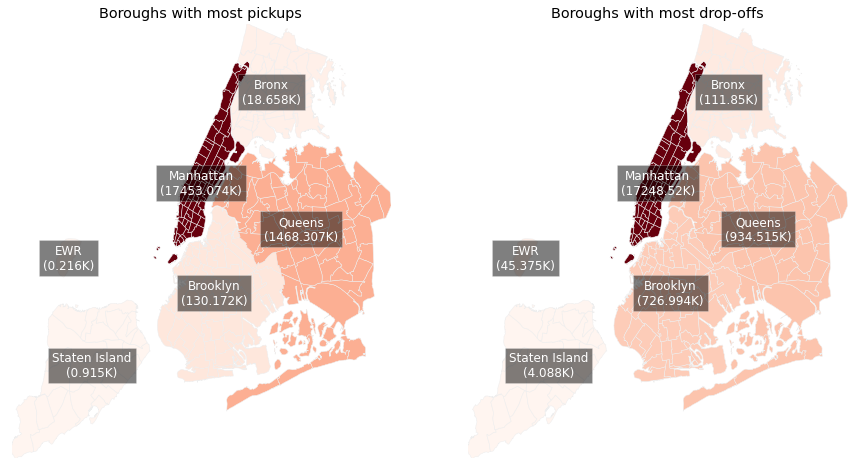

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
plot_region(ax, map_data, data = dict(zip(data_borough['pickup_Borough'].tolist(), data_borough['total_trips_pickup'].tolist())))
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
plot_region(ax, map_data, data = dict(zip(data_borough['pickup_Borough'].tolist(), data_borough['total_trips_dropoff'].tolist())))

In [69]:
data_hours=pick_up_hrs.merge(drop_off_hrs,left_on='pickup_hour', right_on='dropoff_hour', suffixes=['_pickup','_dropoff']).sort_values(by='pickup_hour')

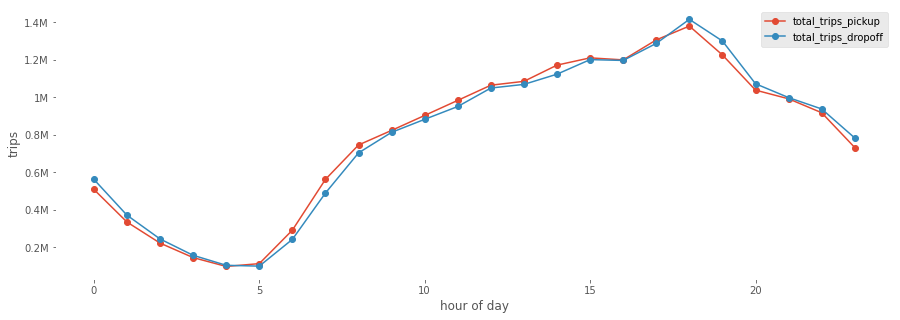

In [156]:
ax = data_hours.plot(x='pickup_hour', y=['total_trips_pickup', 'total_trips_dropoff'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("trips")
ax.set_xlabel("hour of day")
ax.set_facecolor('w')
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}M'.format(x/1e6))
ax.yaxis.set_major_formatter(ticks_y)
plt.show()

In [153]:
def radial_plot(ax, radius, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radius, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}M'.format(x/1e6))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_facecolor('w')
    ax.set_title(title)

In [80]:
q1=pick_up_hrs_distance.query("trip_type=='short'").sort_values(by="pickup_hour")
q2=pick_up_hrs_distance.query("trip_type=='long'").sort_values(by="pickup_hour")
q3=drop_off_hrs_distance.query("trip_type=='short'").sort_values(by="dropoff_hour")
q4=drop_off_hrs_distance.query("trip_type=='long'").sort_values(by="dropoff_hour")

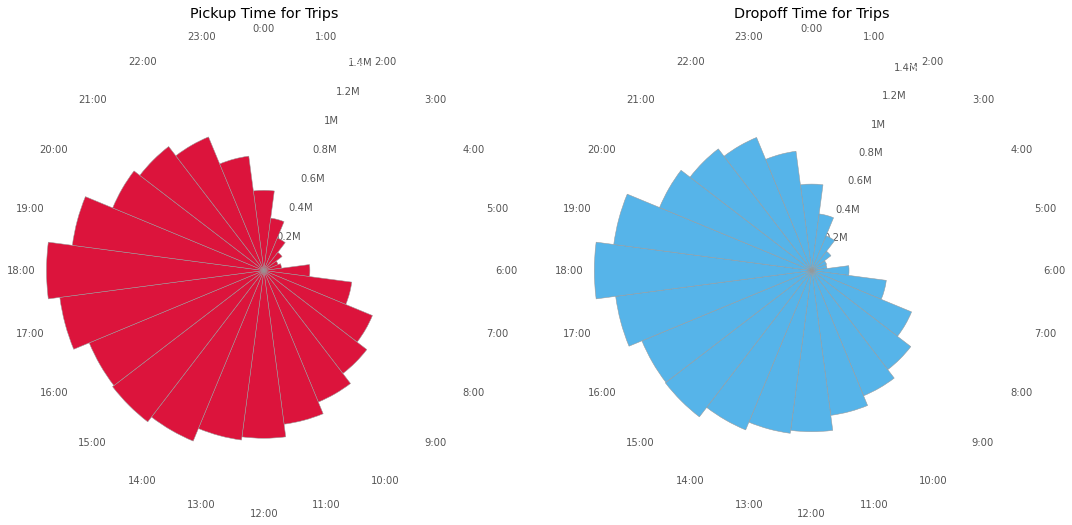

In [154]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))

ax = plt.subplot(1,2,1, polar=True)
radial_plot(ax, np.array(q1['total_trips'].tolist(), dtype="int64"), "Pickup Time for Trips", "#dc143c")

ax = plt.subplot(1,2,2, polar=True)
radial_plot(ax, np.array(q3['total_trips'].tolist(), dtype="int64"), "Dropoff Time for Trips", "#56B4E9")

# Dont RUN

In [153]:
store_df['trip_month']=store_df['trip_month'].astype(str)

In [238]:
with urlopen('https://raw.githubusercontent.com/vaexio/dash-120million-taxi-app/master/aux_data/taxi_zones-tiny.json') as response:
    taxi_zones = json.load(response)

In [239]:
fig = px.choropleth(data_summary_2022_map, geojson=taxi_zones, locations='LocationID', color="total_trips_pickup", color_continuous_scale="Inferno", fitbounds="locations")
fig.write_html('summary_2022_trip_pickups.html')

In [244]:
import plotly.express as px

fig = px.choropleth_mapbox(data_summary_2022_map, geojson=taxi_zones, locations='LocationID', color='total_trips_pickup',
                           color_continuous_scale="Inferno",
                           range_color=(0, 12),
                           zoom=10,
                           mapbox_style="carto-positron",
                           center={"lat": 40.7, "lon": -73.9},
                           opacity=0.5
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('summary_2022_trip_pickups.html')

# RUN

In [98]:
pick_up_trips_zone_amount = df_2022[['pickup_LocationID','pickup_Borough','pickup_Zone', 'total_amount']].groupby(['pickup_LocationID','pickup_Borough','pickup_Zone']).mean().reset_index().rename(columns={0:'avg_total_amount'})
drop_off_trips_zone_amount = df_2022[['dropoff_LocationID','dropoff_Borough','dropoff_Zone', 'total_amount']].groupby(['dropoff_LocationID','dropoff_Borough','dropoff_Zone']).mean().reset_index().rename(columns={0:'avg_total_amount'})
pick_up_trips_borough_amount = df_2022[['pickup_Borough', 'total_amount']].groupby(['pickup_Borough']).mean().reset_index().rename(columns={0:'avg_total_amount'})
drop_off_trips_borough_amount = df_2022[['dropoff_Borough', 'total_amount']].groupby(['dropoff_Borough']).mean().reset_index().rename(columns={0:'avg_total_amount'})

In [95]:
pick_up_trips_zone_distance = df_2022[['pickup_LocationID','pickup_Borough','pickup_Zone', 'trip_distance']].groupby(['pickup_LocationID','pickup_Borough','pickup_Zone']).mean().reset_index().rename(columns={0:'avg_trip_distance'})
drop_off_trips_zone_distance = df_2022[['dropoff_LocationID','dropoff_Borough','dropoff_Zone', 'trip_distance']].groupby(['dropoff_LocationID','dropoff_Borough','dropoff_Zone']).mean().reset_index().rename(columns={0:'avg_trip_distance'})
pick_up_trips_borough_distance = df_2022[['pickup_Borough', 'trip_distance']].groupby(['pickup_Borough']).mean().reset_index().rename(columns={0:'avg_trip_distance'})
drop_off_trips_borough_distance = df_2022[['dropoff_Borough', 'trip_distance']].groupby(['dropoff_Borough']).mean().reset_index().rename(columns={0:'avg_trip_distance'})

In [94]:
pick_up_trips_zone_duration = df_2022[['pickup_LocationID','pickup_Borough','pickup_Zone', 'trip_duration']].groupby(['pickup_LocationID','pickup_Borough','pickup_Zone']).mean().reset_index().rename(columns={0:'avg_trip_duration'})
drop_off_trips_zone_duration = df_2022[['dropoff_LocationID','dropoff_Borough','dropoff_Zone', 'trip_duration']].groupby(['dropoff_LocationID','dropoff_Borough','dropoff_Zone']).mean().reset_index().rename(columns={0:'avg_trip_duration'})
pick_up_trips_borough_duration = df_2022[['pickup_Borough', 'trip_duration']].groupby(['pickup_Borough']).mean().reset_index().rename(columns={0:'avg_trip_duration'})
drop_off_trips_borough_duration = df_2022[['dropoff_Borough', 'trip_duration']].groupby(['dropoff_Borough']).mean().reset_index().rename(columns={0:'avg_trip_duration'})

In [116]:
data_zone_amount=pick_up_trips_zone_amount.merge(drop_off_trips_zone_amount,left_on='pickup_LocationID', right_on='dropoff_LocationID', suffixes=['_pickup','_dropoff'])
data_borough_amount=pick_up_trips_borough_amount.merge(drop_off_trips_borough_amount,left_on='pickup_Borough', right_on='dropoff_Borough', suffixes=['_pickup','_dropoff'])
data_zone_distance=pick_up_trips_zone_distance.merge(drop_off_trips_zone_distance,left_on='pickup_LocationID', right_on='dropoff_LocationID', suffixes=['_pickup','_dropoff'])
data_borough_distance=pick_up_trips_borough_distance.merge(drop_off_trips_borough_distance,left_on='pickup_Borough', right_on='dropoff_Borough', suffixes=['_pickup','_dropoff'])
data_zone_duration=pick_up_trips_zone_duration.merge(drop_off_trips_zone_duration,left_on='pickup_LocationID', right_on='dropoff_LocationID', suffixes=['_pickup','_dropoff'])
data_borough_duration=pick_up_trips_borough_duration.merge(drop_off_trips_borough_duration,left_on='pickup_Borough', right_on='dropoff_Borough', suffixes=['_pickup','_dropoff'])

C:\Python\Anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


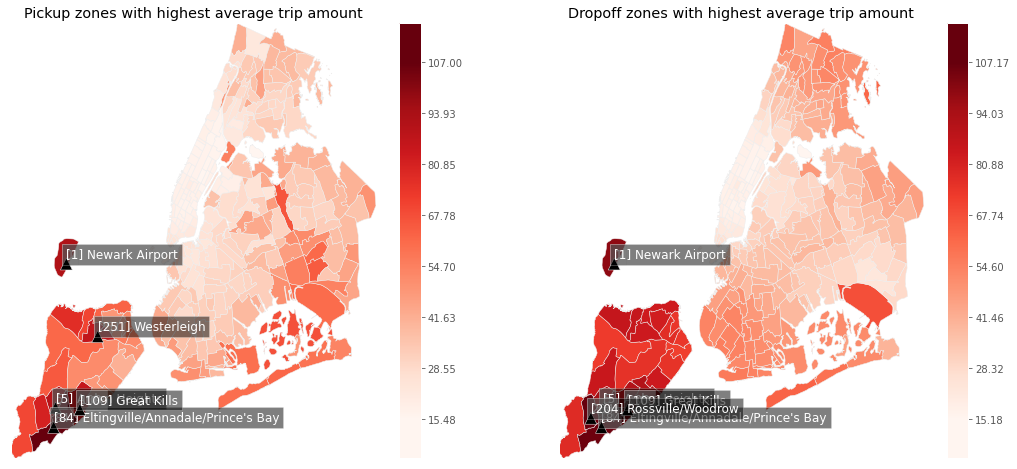

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup zones with highest average trip amount")
plot_zone(ax, map_data, data=dict(zip(data_zone_amount['pickup_LocationID'].tolist(), data_zone_amount['total_amount_pickup'].tolist())), text=data_zone_amount.sort_values(by=['total_amount_pickup'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Dropoff zones with highest average trip amount")
plot_zone(ax, map_data, data=dict(zip(data_zone_amount['pickup_LocationID'].tolist(), data_zone_amount['total_amount_dropoff'].tolist())), text=data_zone_amount.sort_values(by=['total_amount_dropoff'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())

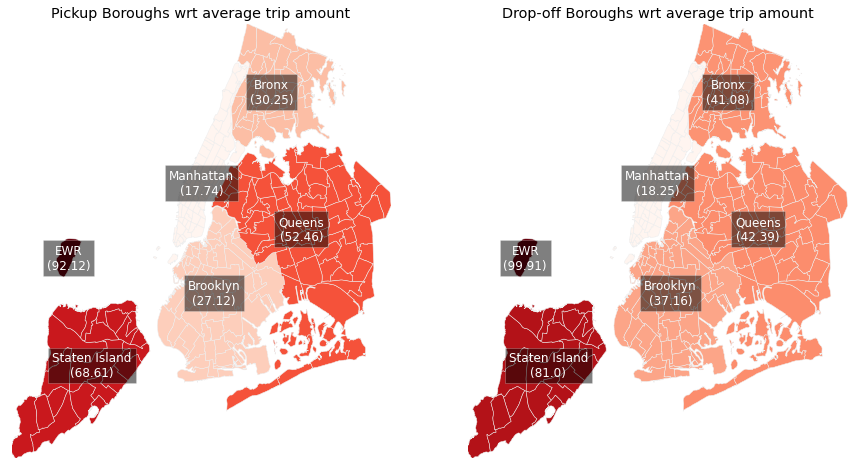

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup Boroughs wrt average trip amount")
plot_region(ax, map_data, data = dict(zip(data_borough_amount['pickup_Borough'].tolist(), data_borough_amount['total_amount_pickup'].tolist())),r=False)
ax = plt.subplot(1, 2, 2)
ax.set_title("Drop-off Boroughs wrt average trip amount")
plot_region(ax, map_data, data = dict(zip(data_borough_amount['pickup_Borough'].tolist(), data_borough_amount['total_amount_dropoff'].tolist())),r=False)

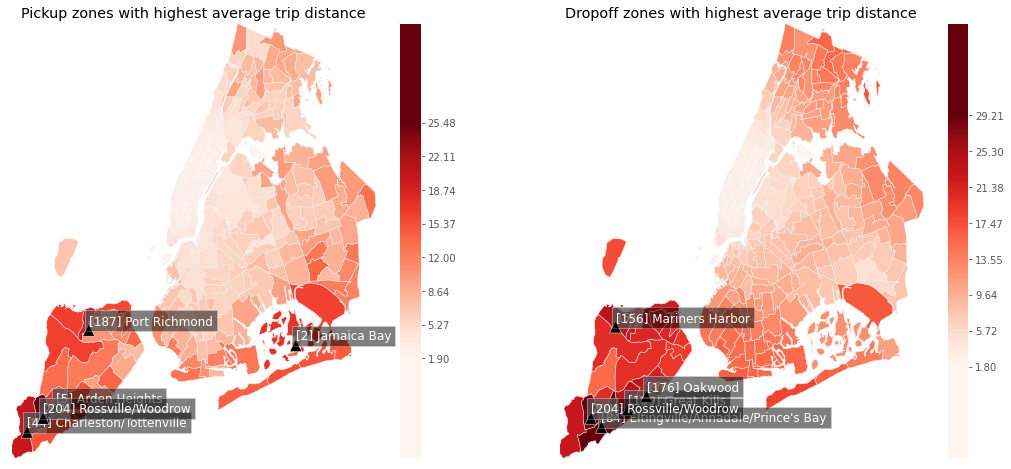

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup zones with highest average trip distance")
plot_zone(ax, map_data, data=dict(zip(data_zone_distance['pickup_LocationID'].tolist(), data_zone_distance['trip_distance_pickup'].tolist())), text=data_zone_distance.sort_values(by=['trip_distance_pickup'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Dropoff zones with highest average trip distance")
plot_zone(ax, map_data, data=dict(zip(data_zone_distance['pickup_LocationID'].tolist(), data_zone_distance['trip_distance_dropoff'].tolist())), text=data_zone_distance.sort_values(by=['trip_distance_dropoff'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())

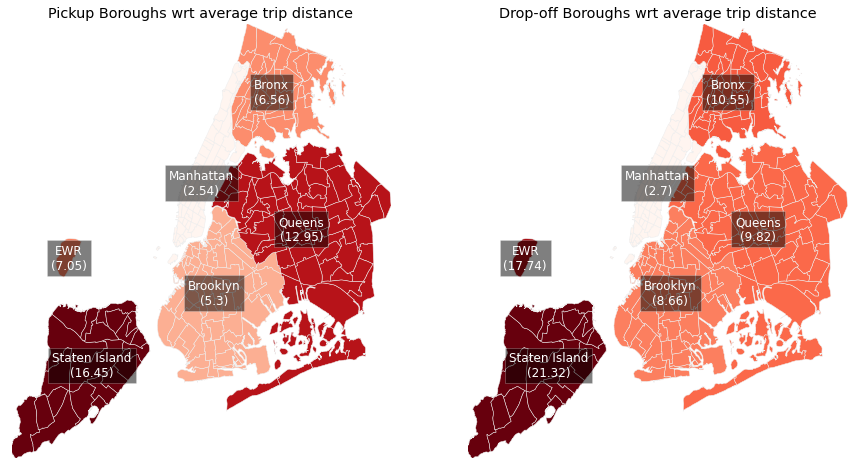

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup Boroughs wrt average trip distance")
plot_region(ax, map_data, data = dict(zip(data_borough_distance['pickup_Borough'].tolist(), data_borough_distance['trip_distance_pickup'].tolist())),r=False)
ax = plt.subplot(1, 2, 2)
ax.set_title("Drop-off Boroughs wrt average trip distance")
plot_region(ax, map_data, data = dict(zip(data_borough_distance['pickup_Borough'].tolist(), data_borough_distance['trip_distance_dropoff'].tolist())),r=False)

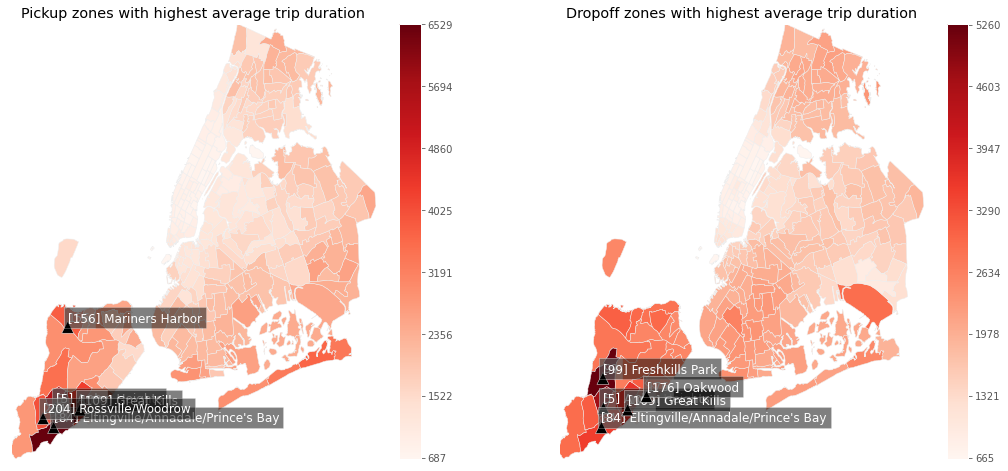

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup zones with highest average trip duration")
plot_zone(ax, map_data, data=dict(zip(data_zone_duration['pickup_LocationID'].tolist(), data_zone_duration['trip_duration_pickup'].tolist())), text=data_zone_duration.sort_values(by=['trip_duration_pickup'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Dropoff zones with highest average trip duration")
plot_zone(ax, map_data, data=dict(zip(data_zone_duration['pickup_LocationID'].tolist(), data_zone_duration['trip_duration_dropoff'].tolist())), text=data_zone_duration.sort_values(by=['trip_duration_dropoff'], ascending=False).set_index("pickup_LocationID").head(5).index.tolist())

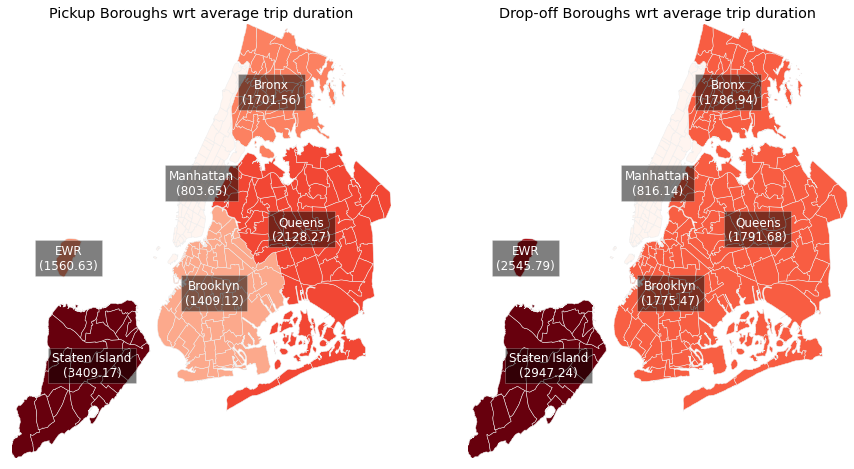

In [145]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Pickup Boroughs wrt average trip duration")
plot_region(ax, map_data, data = dict(zip(data_borough_duration['pickup_Borough'].tolist(), data_borough_duration['trip_duration_pickup'].tolist())),r=False)
ax = plt.subplot(1, 2, 2)
ax.set_title("Drop-off Boroughs wrt average trip duration")
plot_region(ax, map_data, data = dict(zip(data_borough_duration['pickup_Borough'].tolist(), data_borough_duration['trip_duration_dropoff'].tolist())),r=False)